In [234]:
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as linalg
import cv2
import matplotlib.pyplot as mpplt


In [235]:

source = cv2.imread('/Users/dianatat/Documents/Master/C2 Optimisation techniques for CV/Project/week2/pictures/source_04.jpg') # source
mask = cv2.imread('/Users/dianatat/Documents/Master/C2 Optimisation techniques for CV/Project/week2/pictures/mask_04.jpg') # mask
target = cv2.imread('/Users/dianatat/Documents/Master/C2 Optimisation techniques for CV/Project/week2/pictures/target_04.jpg') # target
  

  

def display_image(image_data):
  # show the image
  mpplt.figure(figsize=(16,16))
  for i in range(3):
    if(i == 0):
      img_string = 'source'
    elif(i == 1):
      img_string = 'mask'
    else:
      img_string = 'target'
    img = image_data[img_string]
    mpplt.subplot(1,3,i+1)
    mpplt.imshow(img[:,:,[2,1,0]])
    

In [236]:
def preprocess(image_data):
  # extract image data
  source = image_data['source']
  mask = image_data['mask']
  target = image_data['target']
  
  # get image shape and offset
  Hs,Ws,_ = source.shape
  Ht,Wt,_ = target.shape
  Ho, Wo = image_data['dims']
  
  # adjust source and mask if offset is negative.
  # if mask is rolled eg. from the top it rolls 
  # to the bottom, crop the rolled portion
  if(Ho < 0):
    mask = np.roll(mask, Ho, axis=0)
    source = np.roll(source, Ho, axis=0)
    mask[Hs+Ho:,:,:] = 0 # added because Ho < 0
    source[Hs+Ho:,:,:] = 0
    Ho = 0
  if(Wo < 0):
    mask = np.roll(mask, Wo, axis=1)
    source = np.roll(source, Wo, axis=1)
    mask[:,Ws+Wo:,:] = 0
    source[:,Ws+Wo:,:] = 0
    Wo = 0
  
  # mask region on target
  H_min = Ho
  H_max = min(Ho + Hs, Ht)
  W_min = Wo
  W_max = min(Wo + Ws, Wt)
  
  # crop source and mask if they lie outside the bounds of the target
  source = source[0:min(Hs, Ht-Ho),0:min(Ws, Wt-Wo),:]
  mask = mask[0:min(Hs, Ht-Ho),0:min(Ws, Wt-Wo),:]
  
  return {'source':source, 'mask': mask, 'target': target, 'dims':[H_min,H_max,W_min,W_max]}
  

In [237]:
# performs naive cut-paste from source to target
def naive_copy(image_data):
  # extract image data
  source = image_data['source']
  mask = image_data['mask']
  target = image_data['target']
  dims = image_data['dims']
  
  target[dims[0]:dims[1],dims[2]:dims[3],:] = target[dims[0]:dims[1],dims[2]:dims[3],:] * (1 - mask) + source * mask
  
  return target
  

In [238]:
def get_subimg(image, dims):
   return image[dims[0]:dims[1], dims[2]:dims[3]]

def poisson_blending(image, GRAD_MIX):
  # comparison function
  def _compare(val1, val2):
    if(abs(val1) > abs(val2)):
      return val1
    else:
      return val2
  
  # membrane (region where Poisson blending is performed)
  mask = image['mask']
  Hs,Ws = mask.shape
  num_pxls = Hs * Ws
  
  # source and target image
  source = image['source'].flatten(order='C')
  target_subimg = get_subimg(image['target'], image['dims']).flatten(order='C')

  # initialise the mask, guidance vector field and laplacian
  mask = mask.flatten(order='C')
  guidance_field = np.empty_like(mask)
  laplacian = sps.lil_matrix((num_pxls, num_pxls), dtype='float64')

  for i in range(num_pxls):
    # construct the sparse laplacian block matrix
    # and guidance field for the membrane
    if(mask[i] > 0.99):
      
      laplacian[i, i] = 4
      
      # construct laplacian, and compute source and target gradient in mask
      if(i - Ws > 0):
        laplacian[i, i-Ws] = -1
        Np_up_s = source[i] - source[i-Ws]
        Np_up_t = target_subimg[i] - target_subimg[i-Ws]
      else:
        Np_up_s = source[i]
        Np_up_t = target_subimg[i]
        
      if(i % Ws != 0):
        laplacian[i, i-1] = -1
        Np_left_s = source[i] - source[i-1]
        Np_left_t = target_subimg[i] - target_subimg[i-1]
      else:
        Np_left_s = source[i]
        Np_left_t = target_subimg[i]
        
      if(i + Ws < num_pxls):
        laplacian[i, i+Ws] = -1
        Np_down_s = source[i] - source[i+Ws]
        Np_down_t = target_subimg[i] - target_subimg[i+Ws]
      else:
        Np_down_s = source[i]
        Np_down_t = target_subimg[i]
        
      if(i % Ws != Ws-1):
        laplacian[i, i+1] = -1
        Np_right_s = source[i] - source[i+1]
        Np_right_t = target_subimg[i] - target_subimg[i+1]
      else:
        Np_right_s = source[i]
        Np_right_t = target_subimg[i]
      
      # choose stronger gradient
      if(GRAD_MIX is False):
        Np_up_t = 0
        Np_left_t = 0
        Np_down_t = 0
        Np_right_t = 0
        
      guidance_field[i] = (_compare(Np_up_s, Np_up_t) + _compare(Np_left_s, Np_left_t) + 
                           _compare(Np_down_s, Np_down_t) + _compare(Np_right_s, Np_right_t))

    else:
      # if point lies outside membrane, copy target function
      laplacian[i, i] = 1
      guidance_field[i] = target_subimg[i]
  
  return [laplacian, guidance_field]
  

In [239]:
# linear least squares solver
def linlsq_solver(A, b, dims):
  x = linalg.spsolve(A.tocsc(),b)
  return np.reshape(x,(dims[0],dims[1]))

# stitches poisson equation solution with target
def stitch_images(source, target, dims):
  target[dims[0]:dims[1], dims[2]:dims[3],:] = source
  return target

# performs poisson blending
def blend_image(data, BLEND_TYPE, GRAD_MIX):
  if(BLEND_TYPE == 1):
    image_solution = naive_copy(data)
    
  elif(BLEND_TYPE == 2):
    equation_param = []
    ch_data = {}
    
    # construct poisson equation 
    for ch in range(3):
      ch_data['source'] = data['source'][:,:,ch]
      ch_data['mask'] = data['mask'][:,:,ch]
      ch_data['target'] = data['target'][:,:,ch]
      ch_data['dims'] = data['dims']
      equation_param.append(poisson_blending(ch_data, GRAD_MIX))

    # solve poisson equation
    image_solution = np.empty_like(data['source'])
    for i in range(3):
      image_solution[:,:,i] = linlsq_solver(equation_param[i][0],equation_param[i][1],data['source'].shape)
      
    image_solution = stitch_images(image_solution,image['target'],ch_data['dims'])
    
  else:
    # wrong option
    raise Exception('Wrong option! Available: 1. Naive, 2. Poisson')
      
  return image_solution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


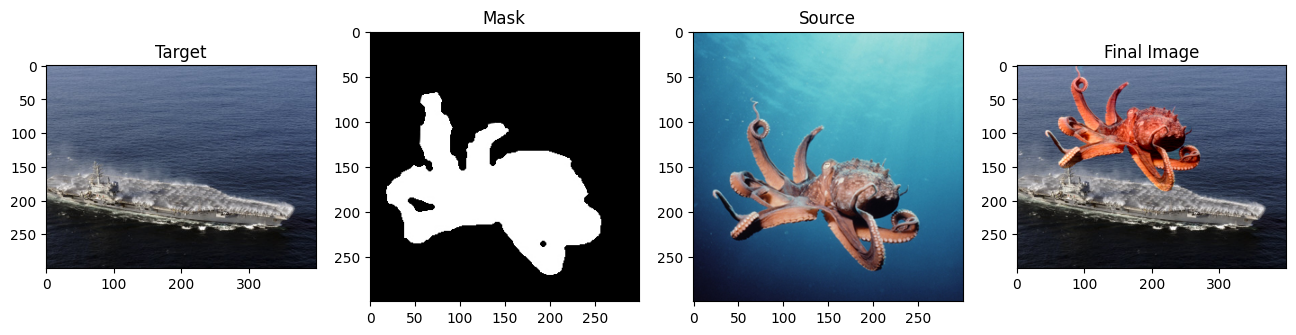

In [242]:
DATA_ROOT = "F:/Projects/"

# Define the target_offsets with the desired shifts
shift_amount = 100  # Adjust this value to control the vertical shift
target_offsets = [[210 - shift_amount, 10], [10 - shift_amount, 28], [140 - shift_amount, 80], [-40 - shift_amount, 90], [60 - shift_amount, 100], [20 - shift_amount, 20], 
                  [-28 - shift_amount, 88], [262 - shift_amount, 240], [315 - shift_amount, 629], [568 - shift_amount, 803], [378 - shift_amount, 806], [297 - shift_amount, 195]]


BLEND_TYPE = 2
GRAD_MIX = True
IMAGE_NAME = "06.jpg"


final_image = blend_image(data, BLEND_TYPE, GRAD_MIX)

mpplt.figure(figsize=(16, 5))  # Adjust the figure size as needed

# Display the target, mask, source, and final images
mpplt.subplot(1, 4, 1)
mpplt.imshow(target[:, :, [2, 1, 0]])
mpplt.title('Target')

mpplt.subplot(1, 4, 2)
mpplt.imshow(mask)
mpplt.title('Mask')

mpplt.subplot(1, 4, 3)
mpplt.imshow(source[:, :, [2, 1, 0]])
mpplt.title('Source')

mpplt.subplot(1, 4, 4)
mpplt.imshow(final_image[:, :, [2, 1, 0]])
mpplt.title('Final Image')

mpplt.show()
